In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy as ppy
import seaborn.apionly as sns
from astropy.io import fits
import os
%matplotlib inline

GPU acceleration not available, sorry
pycuda not installed.


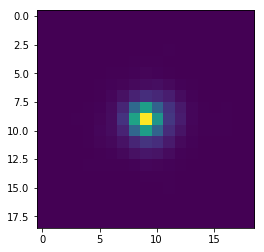

In [178]:
psf_file = 'psf.fits'
hdu = fits.open(psf_file)[0]
psf = hdu.data.astype(float)
plt.imshow(psf)

d_CenA = 3.8 #mpc, https://doi.org/10.1071/AS09063

In [306]:
def make_filter(fits_file, dist, psf, name, MIST_column, red_per_ebv=1.526):
    hdu = fits.open(fits_file)[0]
    exposure = hdu.header['EXPTIME']
    #http://www.stsci.edu/hst/acs/analysis/zeropoints
    ab_zpt = -2.5*np.log10(hdu.header['PHOTFLAM']) - 5.0*np.log10(hdu.header['PHOTPLAM']) - 2.408
    return ppy.instrument.Filter(exposure, ab_zpt, dist, red_per_ebv, psf, name=name, MIST_column=MIST_column)

In [307]:
filters = []
filters.append(make_filter('sbf_im/f814w_1.fits', d_CenA, psf, 'F814W', 'ACS_WFC_F814W'))
filters.append(make_filter('sbf_im/f822n.fits', d_CenA, psf, 'F8230', 'ACS_RAMP_8230'))
filters.append(make_filter('sbf_im/f835n.fits', d_CenA, psf, 'F8365', 'ACS_RAMP_8365'))
filters.append(make_filter('sbf_im/f855n.fits', d_CenA, psf, 'F8560', 'ACS_RAMP_8560'))
filters.append(make_filter('sbf_im/f878n.fits', d_CenA, psf, 'F8800', 'ACS_RAMP_8800'))

In [194]:
#Need to add more to the filters
#For each, we need:
# 1) PSFs (assume same as 814)
# 2) redenning (assume same as 814)

In [195]:
iso_model = ppy.isochrones.Isochrone_Model(filters, MIST_path='HST_ACS_RAMP/', append='.iso.HST_ACS_RAMP')

In [196]:
driv = ppy.driver.Driver(iso_model, gpu=False)

In [295]:
def set_filter_header(head, f):
    head['filter'] = (f.name, 'The HST filter name')
    head['exptime'] = (f._exposure, 'Exposure Time (in sec)')
    head['zeropt'] = (round(f._zero_point, 3), 'Photometric zero point (mag equaling 1 count/s)')
    head['red_ebv'] = (f._red_per_ebv, 'reddening value (A_x / E(B-V))')
    head['bunit'] = ('photons', 'Units of science product')
    head['dist_mod'] = (round(f._dmod, 3), 'Assumed distance modulus to source')
    d_mpc = 10.**(0.2*(f._dmod - 25.))
    head['dist_mpc'] = (round(d_mpc, 3), 'Assumed distance (in Mpc) to source')

In [304]:
def simulate_image(params, N_im, driv, imf_func=ppy.isochrones.salpeter_IMF, imf_desc='Salpeter', a_fe=0.,
                  output_file=None):
    if (output_file is not None) and (os.path.exists(output_file)):
        print('Error: %s already exists'%output_file)
        return
    gal = ppy.galaxy.Galaxy_SSP(params)
    _, images = driv.simulate(gal, N_im, psf=True, fixed_seed=False, imf_func=imf_func)
    phdu = fits.PrimaryHDU()
    phdu.header['AUTHOR'] = 'Ben Cook'
    phdu.header['EMAIL'] = 'bcook@cfa.harvard.edu'
    phdu.header['COMMENT'] = 'Images simulated with PCMDPY code'
    phdu.header['PARAM1'] = (params[0], 'Log Metallicity [Fe/H]')
    phdu.header['PARAM2'] = (params[1], 'Log E(B-V) Dust Extinction')
    phdu.header['PARAM3'] = (params[2], 'Log Npix')
    phdu.header['PARAM4'] = (params[3], 'Log Age (in years)')
    phdu.header['PARAM5'] = (a_fe, 'Log Enrichment [a/Fe]')
    phdu.header['PARAM6'] = (imf_desc, 'Description of IMF')
    phdu.header['NFILTERS'] = (len(driv.filters), 'Number of Filter Images Included')
    hdulist = [phdu]
    for i, f in enumerate(driv.filters):
        phdu.header['FILTER%d'%(i+1)] = (f.name, 'Name of Filter')
        im = images[i]
        hdu = fits.ImageHDU(data=im, name='FILTER%d'%(i+1))
        set_filter_header(hdu.header, f)
        hdu.header['DATAMAX'] = round(np.max(im),3)
        hdu.header['DATAMIN'] = round(np.min(im),3)
        hdulist.append(hdu)
    hdulist = fits.HDUList(hdulist)
    if output_file is not None:
        hdulist.writeto(output_file)
    return hdulist

In [303]:
%%time
sim_hdulist = simulate_image(np.array([0., -1., 3., 10.]), 1024, driv, output_file='simulations/test1.fits')

CPU times: user 2min 42s, sys: 47.8 s, total: 3min 30s
Wall time: 4min


In [290]:
sim_hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU      19   ()      
  1  FILTER1     ImageHDU        17   (128, 128)   float64   
  2  FILTER2     ImageHDU        17   (128, 128)   float64   
  3  FILTER3     ImageHDU        17   (128, 128)   float64   
  4  FILTER4     ImageHDU        17   (128, 128)   float64   
  5  FILTER5     ImageHDU        17   (128, 128)   float64   


In [291]:
sim_hdulist[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
AUTHOR  = 'Ben Cook'                                                            
EMAIL   = 'bcook@cfa.harvard.edu'                                               
PARAM1  =                  0.0 / Log Metallicity [Fe/H]                         
PARAM2  =                 -1.0 / Log E(B-V) Dust Extinction                     
PARAM3  =                  3.0 / Log Npix                                       
PARAM4  =                 10.0 / Log Age (in years)                             
PARAM5  =                  0.0 / Log Enrichment [a/Fe]                          
PARAM6  = 'Salpeter'           / Description of IMF                             
NFILTERS=                   

In [292]:
sim_hdulist[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  128                                                  
NAXIS2  =                  128                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'FILTER1 '           / extension name                                 
FILTER  = 'F814W   '           / The HST filter name                            
EXPTIME =               2288.0 / Exposure Time (in sec)                         
ZEROPT  =               25.947 / Photometric zero point (mag equaling 1 count/s)
RED_EBV =                1.536 / the Reddening value (A_x / E(B-V))             
BUNIT   = 'photons '        

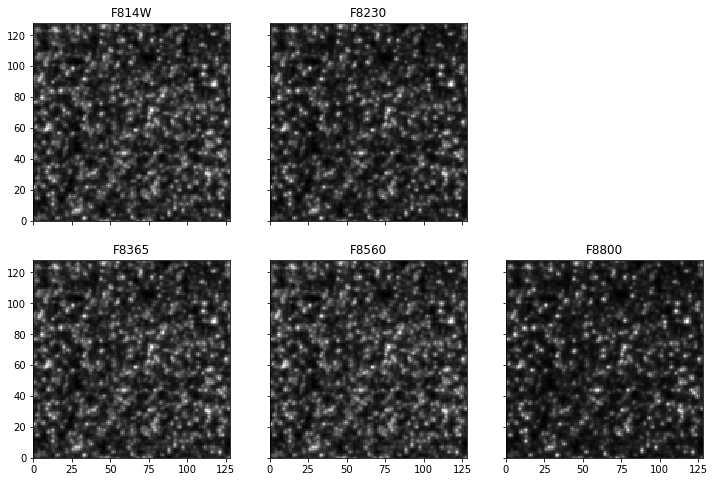

In [298]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(12,8))
axes = axes.flatten()
axes[2].axis('off')
axes = np.delete(axes, 2)
for i in range(5):
    axes[i].imshow(sim_hdulist[i+1].data, cmap='Greys_r')
    axes[i].set_title(sim_hdulist[i+1].header['FILTER'])
    axes[i].set_xlim([0,128])
    axes[i].set_ylim([0, 128])
# plt.tight_layout()

In [305]:
hdu = fits.open('sbf_im/f814w_1.fits')[0]
hdu.header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2300 / Axis length                                    
NAXIS2  =                 2243 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2015-07-02T11:52:47' / Date FITS file was generated                  
IRAF-TLM= '2015-07-02T11:52:47' / Time of last modification                     
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'ACS   '             / identifier for instrument used to acquire data 
                            